In [1]:
import sys
import os
from tempfile import mkdtemp

import numpy as np
from process_bigraph import Composite
from process_bigraph.experiments.parameter_scan import RunProcess


sys.path.insert(0, '..')


from biosimulator_processes.processes.amici_process import UtcAmici
from biosimulator_processes.processes.copasi_process import UtcCopasi

from biosimulator_processes.io import read_report_outputs
from biosimulator_processes.helpers import plot_utc_outputs

Smoldyn is not properly installed in this environment and thus its process implementation cannot be registered. Please consult smoldyn documentation.
Available processes:
[ 'console-emitter',
  'ram-emitter',
  'composite',
  'cobra-process',
  'copasi-process',
  'tellurium-process',
  'utc-amici',
  'utc-copasi',
  'copasi-step',
  'tellurium-step',
  'amici-step',
  'plotter',
  'plotter2d']


In [2]:
omex_dir = './examples/sbml-core/Elowitz-Nature-2000-Repressilator'
omex_fp = omex_dir + '.omex'
sbml_fp = os.path.join(omex_dir, 'BIOMD0000000012_url.xml')
sedml_fp = os.path.join(omex_dir, 'simulation.sedml')
reports_path = os.path.join(omex_dir, 'reports.h5')

Configure and create an Amici UTC instance using just the archive filepath.

In [3]:
utc_amici = UtcAmici(config={'model': {'model_source': omex_dir + '.omex'}})

2024-05-29 17:56:57.390 - amici.sbml_import - INFO - Finished importing SBML                         (4.18E-02s)
2024-05-29 17:56:57.441 - amici.sbml_import - INFO - Finished processing SBML observables            (4.83E-02s)
2024-05-29 17:56:57.446 - amici.sbml_import - INFO - Finished processing SBML event observables      (6.67E-07s)
2024-05-29 17:56:57.469 - amici.de_model - INFO - Finished computing xdot                            (3.15E-03s)
2024-05-29 17:56:57.476 - amici.de_model - INFO - Finished computing x0                              (3.23E-03s)
2024-05-29 17:56:57.494 - amici.de_model - INFO - Finished computing w                               (1.50E-02s)
2024-05-29 17:56:58.159 - amici.de_export - INFO - Finished generating cpp code                      (6.60E-01s)
2024-05-29 17:57:07.065 - amici.de_export - INFO - Finished compiling cpp code                       (8.90E+00s)


In [4]:
# t range parameters set via sedml introspection within archive contents:
utc_amici.t[0], utc_amici.t[-1], utc_amici.duration, utc_amici.step_size, utc_amici.num_steps

(400.0, 600.0, 600, 1.0, 600)

In [5]:
# you can verify this time config against the SEDML file
!cat ./examples/sbml-core/Elowitz-Nature-2000-Repressilator/simulation.sedml

<?xml version="1.0" encoding="UTF-8"?>
<sedML xmlns="http://sed-ml.org/sed-ml/level1/version3" level="1" version="3"
  xmlns:sbml="http://www.sbml.org/sbml/level2/version3">
  <listOfModels>
    <model id="model" language="urn:sedml:language:sbml" source="BIOMD0000000012_url.xml">
      <listOfChanges>
        <changeAttribute target="/sbml:sbml/sbml:model/sbml:listOfSpecies/sbml:species[@id='PX']/@initialAmount" newValue="0"/>
      </listOfChanges>
    </model>
  </listOfModels>
  <listOfSimulations>
    <uniformTimeCourse id="simulation" initialTime="0" outputStartTime="400" outputEndTime="1000" numberOfPoints="600">
      <algorithm kisaoID="KISAO:0000019"/>
    </uniformTimeCourse>
  </listOfSimulations>
  <listOfTasks>
    <task id="task" modelReference="model" simulationReference="simulation"/>
  </listOfTasks>
  <listOfDataGenerators>
    <dataGenerator id="data_gen_time" name="time">
      <math xmlns="http://www.w3.org/1998/Math/MathML">
        <ci> var_time </ci>
      </ma

In [6]:
# run the amici utc simulation with the interface's update method:
amici_results = utc_amici.update()

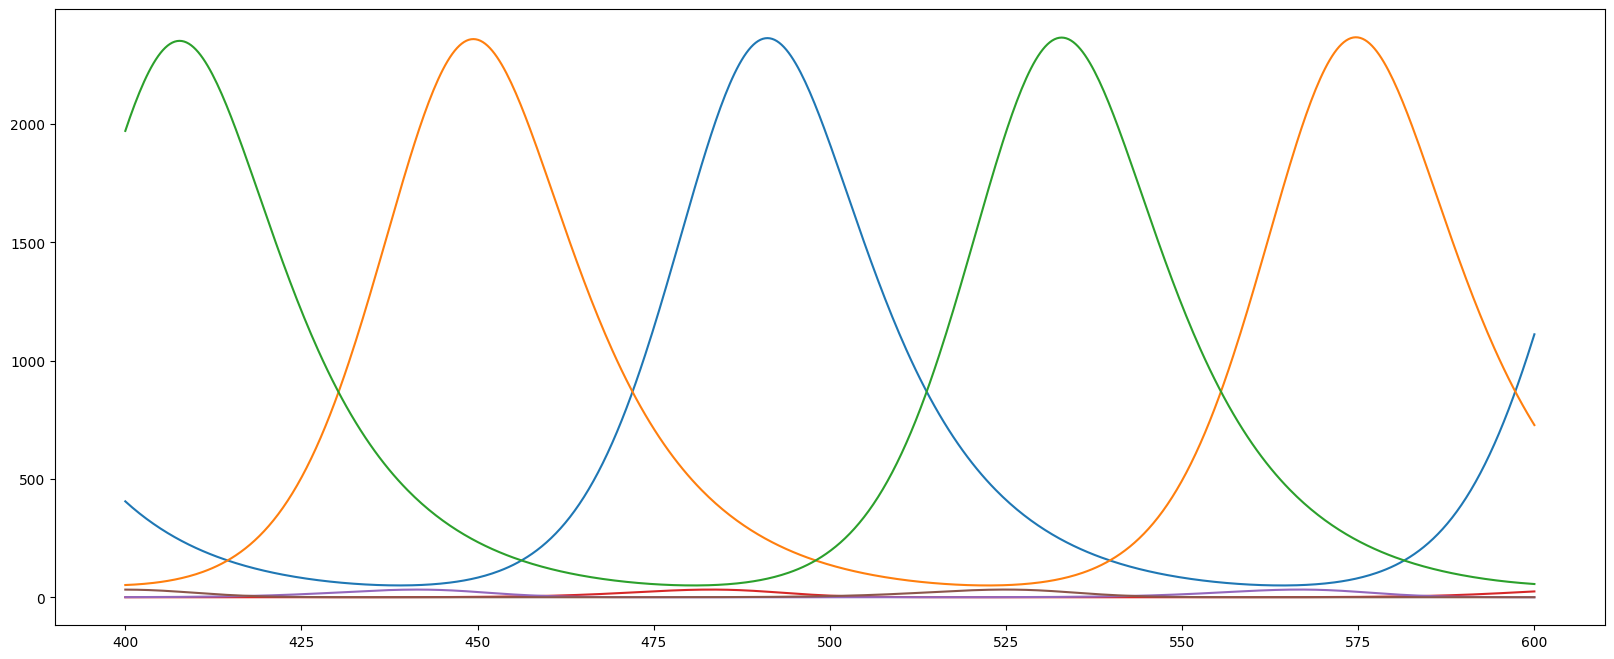

In [7]:
# use built-in plot to plot results
utc_amici.plot_results()

Create a `UtcTellurium` instance as above

In [8]:
from biosimulator_processes.processes.tellurium_process import UtcTellurium


utc_tellurium = UtcTellurium(config={'model': {'model_source': omex_dir + '.omex'}})

In [9]:
tellurium_results = utc_tellurium.update()

In [10]:
tellurium_results

{'floating_species': {'PX': [ 0.          6.6210071   7.70916599  7.49101448  6.98771469  6.42373198
    5.86625206  5.33912431  4.8508497   4.40362015  3.99678481  3.62836362
    3.29579846  2.99632401  2.72716981  2.48566059  2.26927206  2.07565626
    1.90264949  1.74827212  1.61072201  1.48836375  1.37971743  1.28344749
    1.1983511   1.1233465   1.05746204  0.99982615  0.94965804  0.90625895
    0.86900419  0.83733589  0.81075648  0.78882268  0.7711401   0.75735837
    0.74716672  0.74029005  0.73648537  0.73553856  0.73726155  0.7414897
    0.74807953  0.75690665  0.76786386  0.7808596   0.79581639  0.81266955
    0.83136595  0.851863    0.87412782  0.89813637  0.92387267  0.95132812
    0.98050093  1.01139564  1.04402265  1.07839782  1.11454206  1.15248107
    1.19224501  1.23386824  1.27738913  1.3228498   1.370296    1.41977688
    1.47134483  1.52505539  1.58096704  1.63914112  1.69964168  1.76253535
    1.82789121  1.89578066  1.96627728  2.03945671  2.11539648  2.19417585


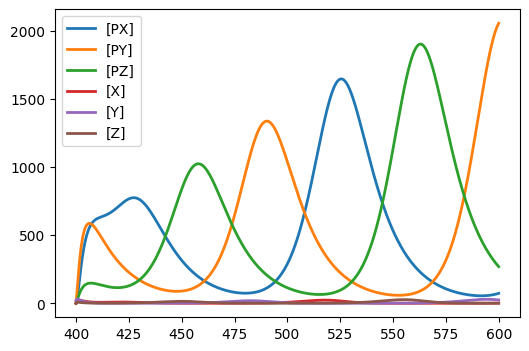

In [11]:
utc_tellurium.simulator.plot()

Now create a `CopasiUtc` instance and extract/visualize results as with the amici process.

In [12]:
utc_amici.step_size

1.0

In [13]:
utc_copasi = UtcCopasi(config={'model': {'model_source': omex_dir + '.omex'}})

In [14]:
copasi_results = utc_copasi.update()

copasi_results

NameError: name 'tc' is not defined

In [ ]:
utc_copasi.tc.plot()

Finally, optionally generate a "ground truth" which we include in the comparison. The default source for ground-truth data is via uploading an omex archive as model source. The report outputs must be included in the archive.

In [ ]:
# Generate comparison matrix from ground truth
from biosimulator_processes.api.compare import generate_comparison

In [ ]:
published_results = read_report_outputs(reports_path)

type(published_results)

In [ ]:
published_results.data

In [ ]:
published_species_outputs = []
for report_output in published_results.data:
    if not report_output.dataset_label.lower() == 'time':
        published_species_outputs.append({report_output.dataset_label: report_output.data})

In [ ]:
published_species_outputs